# Detecting Whether a Shot Has Happened

I found out that it is very costly to run detectron keypoint detector and instance predictor on every single frame of a video.
Even with GPU acceleration, processing one second of a video takes around (24 frames) x 1 second = 24 seconds

Thus, it is important to identify the parts of the video where a shot is happening first using a non-DeepLearning method.

This notebook uses non-compute intensive image-processing techniques to locate the basketball and determine when a shot is happening.

Inspired by: https://www.youtube.com/watch?v=QKVpIo5sfGA

In [1]:
# import skvideo.io
# import skvideo.datasets

from collections import deque

import cv2
import imutils
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

pd.options.display.max_rows = 1000

# Test a Function on an Image

In [2]:
image = cv2.imread("../data/shooting_vids/blah2.png")
output = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# output = locate_bball(gray, output)
# output = get_connected_components(gray, output)

In [3]:
image.shape

(474, 906, 3)

In [4]:
cv2.imshow("test result", np.hstack([output]))
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

# Frame Processing Functions

(some functions are unused in the pipeline. Just there because I experimented different image processing methodologies)

In [2]:
def get_moving_foreground(prev_frame, frame, next_frame):
    """
        Use Three Frame Difference Approach to get moving Foreground Object
        in one frame
        Reference this blog post:
            https://sam-low.com/opencv/frame-differencing.html
    """
    # get differences between frames to detect motion
    diff1 = cv2.absdiff(prev_frame, frame)
    diff2 = cv2.absdiff(frame, next_frame)
    
    # increase contrast between foreground and background by thresholding
    threshold_value = 10
    set_to_value = 255
    _, diff1 = cv2.threshold(diff1, threshold_value, set_to_value, cv2.THRESH_BINARY)
    _, diff2 = cv2.threshold(diff2, threshold_value, set_to_value, cv2.THRESH_BINARY)
    
    # find the overlap between the difference frames to get moving object
    overlap = cv2.bitwise_and(diff1, diff2)
    
    # use median filtering to fill some holes of the moving foreground
    overlap = cv2.medianBlur(overlap,5)
    
    return overlap

In [3]:
def frame_subtraction(bg_frame, cur_frame):
    
    """
        This process of subtracting current frame from bg reference frame
        DOES NOT work well.
        This is because if the camera tilts or shifts slightly the difference
        will be huge. If the leaves of the trees rustle in the background, then
        the difference will be picked up too.
    """
    
    print(type(bg_frame))
    print(type(cur_frame))
    
    diff = cv2.absdiff(bg_frame, cur_frame)
    
    threshold_value = 10
    set_to_value = 255
    _, diff = cv2.threshold(diff, threshold_value, set_to_value, cv2.THRESH_BINARY)
    
    # use median filtering to fill some holes of the moving foreground
    diff = cv2.medianBlur(diff,5)
    
    return diff

In [4]:
def preprocess_vid_frame(frame):
    """
        Do some preprocessing work on a frame of a video to 
        make it ready for image processing techniques.
        1) Convert frame to grayscale
        2) Apply gaussian blur to get rid of noise
    """
    # convert frame to grayscale
    new_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # gaussian blur with 5x5 kernel
    new_frame = cv2.GaussianBlur(new_frame,(5,5), 0)
    
    return new_frame

In [5]:
def stack_frames(frames):
    """
        Use bitwise OR to stack frames together
    """
    res = cv2.bitwise_or(frames[0], frames[1])
    
    for i in range(2, len(frames)):
        res = cv2.bitwise_or(res, frames[i])
    
    return res

In [6]:
def shot_parabola(frame):
    """
        Determine if a shot parabola exists in frame
    """
    
    frame = cv2.Canny(frame,threshold1 = 70, threshold2 = 120)
#     cv2.imshow('canny parabola', frame)

In [7]:
def locate_bball(frame, output):
    """
        Use Hough Circle method
        to locate basketball in frame
        
        Reference: https://www.pyimagesearch.com/2014/07/21/
                   detecting-circles-images-using-opencv-hough-circles/
        
        output frame is the frame you want to draw the
        identifier circle on
    """
    
    # canny edge test
    frame = cv2.Canny(frame,threshold1 = 70, threshold2 = 120)
#     cv2.imshow('canny edge', frame)
    
    
    circles = cv2.HoughCircles(frame, cv2.HOUGH_GRADIENT, dp = 2, minDist = 400,
                               param1 = 5, param2 = 65,
                               minRadius = 0, maxRadius = 60)
    
#     circles = cv2.HoughCircles(frame, cv2.HOUGH_GRADIENT, dp = 5, minDist = 20,
#                                param1 = 50, param2 = 100,
#                                minRadius = 0, maxRadius = 300)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        
        for (x,y,r) in circles:
            # draw the outer circle
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)
            # draw the center of the circle
            cv2.circle(output, (x, y), 2, (0, 255, 0), 3)
    
    return output

In [8]:
def get_connected_components(frame, output):
    """
        Get connected pixel blobs
        Reference: https://stackoverflow.com/questions/35854197/
                   how-to-use-opencvs-connected-components-with-stats-in-python
                   
        Input frame is a frame that has been thresholded
        Output frame is frame to draw connected component results on
    """
    
    connectivity = 4
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(frame,
                                                                            connectivity,
                                                                            cv2.CV_32S)
    
    for (x,y) in centroids:
        # draw the center of the circle
        x, y = int(x), int(y)
        cv2.circle(output, (x, y), 2, (0, 255, 0), 3)
        
    return output

In [9]:
def get_blobs(frame, output):
    """
        Get all the blobs (connected components of white pixels)
        in a thresholded black and white image
        
        Reference: https://www.pyimagesearch.com/2015/05/25/
                   basic-motion-detection-and-tracking-with-python-and-opencv/
                   
        Blobs info is a list of dictionaries containing coordinates
        and size of blobs
    """
    
    cnts = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    blobs_info = []
    
    # loop over the contours
    for c in cnts:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < 100:
            continue
            
        # find the bounding box for the contour
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # store blobs information into list of dictionaries
        b_info = {}
        b_info['x'], b_info['y'] = x, y
        b_info['width'], b_info['height'] = w, h
        
        blobs_info.append(b_info)
    
    return output, blobs_info

In [10]:
def opening(frame):
    
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(frame, cv2.MORPH_OPEN, kernel)
    
    return closing

In [11]:
def closing(frame):
    
    kernel = np.ones((15,15),np.uint8)
    closing = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, kernel)
    
    return closing

# Utility Function to combine multiple frames into one frame for convenient plotting

In [12]:
def combine_frames(grid_size, frames, combined_width):
    """
        Expects frames to be a dictionary mapping grid location to frame
        (0,0)  (0,1)  (0,2)
        (1,0)  (1,1)  (1,2)
        Expects all frames to be same dimensions and have same number of color chanels
    """
    color_chanels = frames[(0,0)].shape[2]
    height, width = frames[(0,0)].shape[0], frames[(0,0)].shape[1]
    
    combined_frame = np.zeros((height * grid_size[0],
                               width  * grid_size[1],
                               color_chanels), dtype = "uint8")
    
    for (grid_r, grid_c), frame in frames.items():
        combined_frame[grid_r * height : (grid_r + 1) * height,
                       grid_c * width  : (grid_c + 1) * width , : ] = frame
    
    combined_frame_resized = imutils.resize(combined_frame, width=combined_width)
#     cv2.imshow(combined_frame_resized)
    
    return combined_frame_resized

In [16]:
frames = {
    (0,0) : image,
    (0,1) : image
}
combined = combine_frames(grid_size = (2,3), frames = frames, combined_width = 1500)

cv2.imshow("Combined frames", combined)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

# Run Video Processing - Find all blobs

In [119]:
def find_blobs(video):
    # record the last 3 frames of video for foreground detection
    frames = deque()
    frames.append(video.read()[1])
    frames.append(video.read()[1])
    frames.append(video.read()[1])

    # record the last 50 frames of foreground detection for frame stacking
    frames_foreground = deque()


    # record blobs information
    blobs_info = []

    frame_count = 0
    while(video.isOpened()):
        frame_count += 1

        # current frame of consideration is the middle frame in frames deque
        cur_frame = frames[1]
        cur_frame = preprocess_vid_frame(cur_frame)

        # find moving foreground
        foreground = get_moving_foreground(preprocess_vid_frame(frames[0]), 
                                           preprocess_vid_frame(frames[1]),
                                           preprocess_vid_frame(frames[2]))
        
        
        # use closing technique to "close up" blobs
        foreground = opening(foreground)
        foreground = closing(foreground)
        


        # find blobs and record blobs information
        blobs_frame = cv2.cvtColor(foreground, cv2.COLOR_GRAY2RGB)
        blobs_frame, frame_blobs_info = get_blobs(foreground, blobs_frame)
#         blobs_frame_2, _ = get_blobs(foreground, cv2.cvtColor(foreground, cv2.COLOR_GRAY2RGB))
        
        # frame_blobs_info contains all information of blobs for current frame
        frame_blobs_info = [{**{'frame_idx': frame_count}, **fbi} for fbi in frame_blobs_info]
        blobs_info.extend(frame_blobs_info)
        


        # stack last 10 foreground frames together
#         frames_foreground.append(foreground)
#         if (len(frames_foreground) > 50):
#             frames_foreground.popleft()
#             stacked_foregrounds = stack_frames(frames_foreground)
# #             cv2.imshow('Foregrounds stacked', stacked_foregrounds)
# #             shot_parabola(stacked_foregrounds)


        f = {
            (0,0): frames[1],
            (0,1): cv2.cvtColor(foreground, cv2.COLOR_GRAY2RGB),
            (1,0): blobs_frame
        }
        r = combine_frames((2,2), f, 1600)
        cv2.imshow('Original & Foreground', r)


        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

        # get next frame
        frames.popleft()
        ret, next_frame = video.read()
        if ret == False:
            break
        frames.append(next_frame)
        
        
    
    width  = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    
    video.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

    blobs_df = pd.DataFrame(blobs_info)
    
    return blobs_df, (width, height)

In [122]:
video = cv2.VideoCapture("../data/shooting_vids/shooting3.mp4")
# video = cv2.VideoCapture("../data/shooting_vids/steph_curry.mp4")

blobs_df, frame_dim = find_blobs(video)
# blobs_df.to_csv("blobs_df.csv")

In [123]:
blobs_df.head(10)

,frame_idx,x,y,width,height
0,10,837,433,43,9
1,10,103,331,45,25
2,10,913,286,23,12
3,10,196,202,31,13
4,10,829,168,13,21
5,10,196,102,16,11
6,10,97,101,40,8
7,10,736,64,23,10
8,10,786,19,20,17
9,10,183,13,19,15


# Function to Find Bball Blobs

In [17]:
def find_bball_blobs(blobs_info_df, frame_size):
    """
        Find all the blobs that are the basketball and label them
        This algo labels the highest blobs as basketballs and tracks these blobs
        through time until it is no longer confident the blob is a basketball.
        
        Each row in blobs_info_df represents one blob opencv found in video
        The dataframe is indexed by blob_idx, but each blob also has a frame_idx.
        One frame may have multiple blobs!
    """
    
    blobs_df = blobs_info_df.copy(deep = True)
    
    # convert y axis so that it goes from bottom to top
    blobs_df['y'] = frame_size[1] - blobs_df['y']
    
    # create column in pandas dataframe for labeling blob as bball
    blobs_df['is_bball'] = False
    
    # hyperparameters to determine what blobs count as a basketball
    # I personally tuned these hyperparameters by trial & observation
    # to minimize the number of false positive & false negative basketballs 
    # (prioritizing minimizing false positives)
    BLOB_DIST     = 100      # the maximum distance allowed between two basketball blobs
    BLOB_SIZE_TOL = 0.3      # the percentage of difference in dimensions allowed between 2 bball blobs
    FRAMES_TOL    = 15       # the number of frames allowed to not see a bball blob before detection stops
    BLOB_MAX      = 1        # the maximum number of blobs that qualify allowed for bball to be returned
    
    
    def get_dist(row, cur_x, cur_y):
        """
            Get distance between blob of current row
            and the blob with coordinates provided
        """
        return ((row['x'] - cur_x)**2 + (row['y'] - cur_y)**2)**(1/2)

    def similar_shape(row, cur_w, cur_h):
        """
            Determine if the dimensions of blob of current row are similar
            to those dimensions provided.
        """
        new_w, new_h = row['width'], row['height']
        tol_w, tol_h = cur_w * BLOB_SIZE_TOL, cur_h * BLOB_SIZE_TOL

        tol_w_lower, tol_w_upper = cur_w - tol_w, cur_w + tol_w
        tol_h_lower, tol_h_upper = cur_h - tol_h, cur_h + tol_h

        return (new_w >= tol_w_lower and new_w <= tol_w_upper and
                new_h >= tol_h_lower and new_h <= tol_h_upper)
        
#         return True

    def find_ball_blob(blob_idx, time_forward):
        """
            Find the ball blob that is closest to the current ball blob
            that is similar in size timewise. Return None is no ball 
            blob can be found
        """
        cur_blob = blobs_df.loc[blob_idx]
        cur_x, cur_y = cur_blob['x'], cur_blob['y']
        cur_w, cur_h = cur_blob['width'], cur_blob['height']
        
        
        # get current blob's frame index
        frame_idx = blobs_df.loc[blob_idx]['frame_idx']
        
        # check the next FRAMES_TOL frames for blob that is basketball
        # (some frames there might not be a basketball detected.
        #  don't let these frames discontinue basketball detection)
        frame_count = 0
        while (frame_count < FRAMES_TOL):
            # get all the blobs one timestep forward or one timestep backwards
            frame_idx = (frame_idx + 1) if time_forward else (frame_idx - 1)
            blobs = blobs_df[blobs_df['frame_idx'] == frame_idx].copy(deep = True)
            if blobs.empty:
                break
            
            # find the distance of all blobs to current blob
            blobs['distance'] = blobs.apply(get_dist, cur_x = cur_x, cur_y = cur_y, axis = 1)

            # determine if blobs are similar shape to current blob
            blobs['similar_shape'] = blobs.apply(similar_shape, cur_w = cur_w, cur_h = cur_h, axis = 1)

            # rows with nans will evaluate to False & False!
            valid_blobs = blobs[(blobs['distance'] < BLOB_DIST) & (blobs['similar_shape'])]
            valid_blobs = valid_blobs.sort_values(by = ['similar_shape', 'distance'],
                                                  ascending = [False, True])

            # only return most confident blob index if there is less than BLOB_MAX valid blobs
            if valid_blobs.shape[0] == 0 or valid_blobs.shape[0] > BLOB_MAX:
                frame_count += 1
            else:
#                 print("returned something useful")
                return valid_blobs.index[0]
        
        return None
    
    def get_idx_ranges(indices):
        """
            Get the start and end value of continuous indices
            [1,2,3,4,7,8,9,14,15,16] --> [(1,4), (7,9), (14,16)]
            
            Expects a sorted list of indices
        """
        start, end = indices[0], 0
        cur = start + 1
        index_ranges = []
        for i in indices[1:]:
            if i != cur:
                end = cur - 1
                index_ranges.append((start, end))
                start = i
                cur = i + 1
            else:
                cur += 1
            if i == indices[-1]:
                end = i
                index_ranges.append((start, end))
        return index_ranges
    
    
    
    # any blob above 95% of max blob height is considered bball
    # the 95% is used to account for varying shot arcs (ball reaches different heights)
    ball_max_height = blobs_df['y'].max()
    ball_effective_height = ball_max_height * 0.80
    blobs_df.loc[blobs_df['y'] >= ball_effective_height, 'is_bball'] = True
    
    
    # get the indices of is_bball == True already
    ball_idxs = blobs_df.index[blobs_df['is_bball']].tolist()
    ball_idx_ranges = get_idx_ranges(ball_idxs)

    for (ball_start, ball_end) in ball_idx_ranges:
        
        print((ball_start, ball_end))
        
        # trace balls backwards and forwards
        for time_forward in [True, False]:
        
            # trace the balls until they can't be found
            ball_idx = ball_end if time_forward else ball_start
            cnt = 0
            while(True):
                cnt += 1
                # get previous or next ball index
                ball_idx = find_ball_blob(ball_idx, time_forward = time_forward)
                # if no ball is found, stop looking
                if ball_idx is None:
                    if time_forward:
                        print(f"Time forwards : {cnt} number of balls found")
                    if not time_forward:
                        print(f"Time backwards: {cnt} number of balls found")
                    break
                # label ball
                blobs_df.loc[ball_idx, "is_bball"] = True
        
    
    # convert y axis back so that it can be plotted by opencv
    blobs_df['y'] = frame_dim[1] - blobs_df['y']
    
    return blobs_df

In [144]:
bball_blobs_df = find_bball_blobs(blobs_df, frame_dim)
# bball_blobs_df.to_csv("bball_blobs_df.csv")
bball_blobs_df.head()

(5, 11)
Time forwards : 3 number of balls found
Time backwards: 1 number of balls found
(30, 44)
Time forwards : 1 number of balls found
Time backwards: 1 number of balls found
(66, 72)
Time forwards : 1 number of balls found
Time backwards: 2 number of balls found
(94, 106)
Time forwards : 3 number of balls found
Time backwards: 2 number of balls found
(128, 141)
Time forwards : 1 number of balls found
Time backwards: 1 number of balls found
(163, 177)
Time forwards : 1 number of balls found
Time backwards: 2 number of balls found
(200, 211)
Time forwards : 1 number of balls found
Time backwards: 3 number of balls found
(227, 233)
Time forwards : 2 number of balls found
Time backwards: 1 number of balls found
(235, 235)
Time forwards : 1 number of balls found
Time backwards: 3 number of balls found
(239, 242)
Time forwards : 1 number of balls found
Time backwards: 1 number of balls found
(263, 263)
Time forwards : 1 number of balls found
Time backwards: 1 number of balls found
(267, 2

,frame_idx,x,y,width,height,is_bball
0,10,837,433.0,43,9,False
1,10,103,331.0,45,25,False
2,10,913,286.0,23,12,False
3,10,196,202.0,31,13,False
4,10,829,168.0,13,21,True


In [145]:
bball_blobs_df.head()

,frame_idx,x,y,width,height,is_bball
0,10,837,433.0,43,9,False
1,10,103,331.0,45,25,False
2,10,913,286.0,23,12,False
3,10,196,202.0,31,13,False
4,10,829,168.0,13,21,True


# Add Shot index for BBall_df

In [129]:
def add_shot_info_to_df(bball_df):
    df = bball_df.copy(deep = True)
    
    df = df[df['is_bball'] == True]
    df['shot_idx'] = 0
    
    # group basketballs into shots based on their frame indices
    cur_frame = df['frame_idx'].iloc[0]
    cur_shot_idx = 0
    FRAME_TOL = 10
    for i, blob in df.iterrows():
        if blob['frame_idx'] > cur_frame + 10:
            cur_shot_idx += 1

        df.loc[i, 'shot_idx'] = cur_shot_idx
        cur_frame = blob['frame_idx']

    # drop any shots where there are not enough frames or too many frames
    df = df.groupby("shot_idx").filter(lambda x: len(x) >= 15 and len(x) <= 85)
    
    # label the basketballs before they hit the rim
    
    return df

In [143]:
bball_info_df = add_shot_info_to_df(bball_blobs_df)
# bball_info_df.to_csv("bball_info_df_2.csv")
bball_info_df.head()

,frame_idx,x,y,width,height,is_bball,shot_idx
1596,549,238,323.0,32,32,True,2
1599,552,226,284.0,33,35,True,2
1600,553,222,276.0,30,40,True,2
1601,554,212,271.0,36,40,True,2
1607,557,199,257.0,34,36,True,2


# Plot Shot Arcs in Plotly

In [35]:
import plotly.graph_objects as go

In [127]:
# stores width, height
frame_dim

(960.0, 544.0)

In [ ]:
# datastructure to store shot arcs


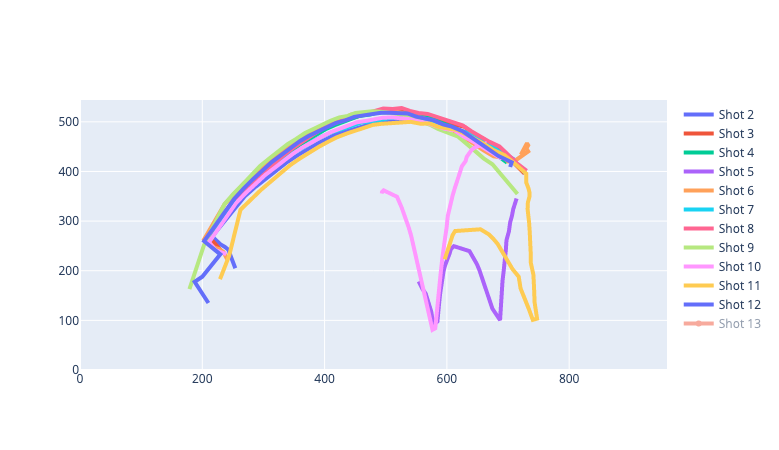

In [131]:
fig = go.Figure()
fig.update_xaxes(range=[0, frame_dim[0]])
fig.update_yaxes(range=[0, frame_dim[1]])


for name, group in bball_info_df.groupby('shot_idx'):
    trace = go.Scatter(line = dict(width=4))
    trace.name = f"Shot {name}"
    trace.x = group['x'] + group['width']/2
    trace.y = frame_dim[1] - (group['y'] + group['height']/2)
    fig.add_trace(trace)

    
fig.show()

# Function to plot basketball bounding box

In [132]:
def plot_bball_bbox(output_frame, bball_info_df, frame_idx):

    # find corresponding bball blob information in frame_idx
    bball = bball_info_df[(bball_info_df['frame_idx'] == frame_idx) &
                          (bball_info_df['is_bball'])]
    
    for _, blob in bball.iterrows():
        x, y, w, h = int(blob['x']), int(blob['y']), int(blob['width']), int(blob['height'])
        cv2.rectangle(output_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(output_frame, "Basketball!", (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
    return output_frame

# Function to plot basketball centroid

In [133]:
def plot_bball_centroid(output_frame, bball_info_df, frame_idx):
    
    # find corresponding bball blob information in frame_idx
    bball = bball_info_df[(bball_info_df['frame_idx'] == frame_idx) &
                          (bball_info_df['is_bball'])]
    
    for _, blob in bball.iterrows():
        x, y, w, h = int(blob['x']), int(blob['y']), int(blob['width']), int(blob['height'])
        c_x, c_y = int(x + w/2), int(y+h/2)
        
        cv2.circle(output_frame,(c_x,c_y), 5, (0,255,0), -1)
        
    return output_frame

# Plot Shot Arcs on Video

In [134]:
prev_shots_frame = np.zeros((int(frame_dim[1]),
                             int(frame_dim[0]),
                             3), dtype = "uint8")

cur_shots_frame  = np.zeros((int(frame_dim[1]),
                             int(frame_dim[0]),
                             3), dtype = "uint8")

In [59]:
cur_shots_frame.shape

(544, 960, 3)

In [138]:
def plot_bball_arc(video, bball_info_df):
    video.read()[1]
    
    # frame to hold all previous shot basketball locations
    prev_shots_frame = np.zeros((int(frame_dim[1]),
                                 int(frame_dim[0]),
                                 3), dtype = "uint8")
    # frame to hold all current shot basketball locations
    cur_shots_frame  = np.zeros((int(frame_dim[1]),
                                 int(frame_dim[0]),
                                 3), dtype = "uint8")
    
    frame_idx = 0
    cur_shot_idx = bball_info_df['shot_idx'].iloc[0]
    while(video.isOpened()):
        frame_idx += 1
        ret, cur_frame = video.read()
        if not ret:
            break
        
        # get the bball blob info corresponding to current frame
        bball_shot_row = bball_info_df[bball_info_df['frame_idx']==frame_idx]
        # if there is a basketball
        if bball_shot_row.shape[0] > 0:
            bball_shot_idx = bball_shot_row['shot_idx'].iloc[0]
            if bball_shot_idx != cur_shot_idx:
                cur_shot_idx = bball_shot_idx
                # make shots red instead of green
                cur_shots_frame[np.all((cur_shots_frame==[0,255,0]), axis = -1)] = [0,0,130]
                prev_shots_frame = cv2.bitwise_or(prev_shots_frame,
                                                  cur_shots_frame)
                prev_shots_frame = prev_shots_frame
                cur_shots_frame  = np.zeros((int(frame_dim[1]),
                                             int(frame_dim[0]),
                                             3), dtype = "uint8")

        
        bball_bbox_frame = cur_frame.copy()
        bball_bbox_frame = plot_bball_bbox(bball_bbox_frame, bball_info_df, frame_idx)
        cur_shots_frame = plot_bball_centroid(cur_shots_frame, bball_info_df, frame_idx)


        f = {
            (0,0): cur_frame,
            (0,1): bball_bbox_frame,
            (1,0): cv2.bitwise_or(prev_shots_frame, cur_shots_frame),
            (1,1): cv2.bitwise_or(cv2.bitwise_or(cur_frame, prev_shots_frame), cur_shots_frame)
        }
        
        r = combine_frames((2,2), f, 1200)
        cv2.imshow('Basketball Labeled', r)


        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


    video.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [141]:
video = cv2.VideoCapture("../data/shooting_vids/shooting3.mp4")

plot_bball_arc(video, bball_info_df)